In [1]:
import pickle
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kafka import KafkaConsumer
from sklearn.metrics import f1_score
import copy
from collections import deque
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
from river import drift

In [18]:
class GraphNet(nn.Module):
    def __init__(self, in_channels, gcn_hidden, dnn_hidden, out_channels, dropout=0.1):
        super().__init__()
        # -- GNN layers --
        self.gcn1 = GCNConv(in_channels, gcn_hidden)
        self.gcn2 = GCNConv(gcn_hidden, gcn_hidden)
        
        self.dropout = nn.Dropout(p=dropout)

        # -- DNN layers --
        self.lin1 = nn.Linear(gcn_hidden, dnn_hidden)
        self.lin2 = nn.Linear(dnn_hidden, out_channels)

    def forward(self, x, edge_index):
        # ----- GNN stage -----
        x = self.gcn1(x, edge_index)   # shape: [num_nodes, gcn_hidden]
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.gcn2(x, edge_index)   # shape: [num_nodes, gcn_hidden]
        x = F.relu(x)
        x = self.dropout(x)

        # ----- DNN stage -----
        x = self.lin1(x)              # shape: [num_nodes, dnn_hidden]
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.lin2(x)              # shape: [num_nodes, out_channels]

        return F.log_softmax(x, dim=1) # for multi-class or binary classification

In [19]:
with open('scaler.pkl', 'rb') as scaler_file:
    scaler = joblib.load(scaler_file)
feature_columns = scaler.feature_names_in_
print("Scaler loaded successfully!")

Scaler loaded successfully!


In [20]:
#Load data stream
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False,
    consumer_timeout_ms=5000
)

if consumer.bootstrap_connected():
    print("Successfully connected to Kafka broker")
else:
    print("Couldn't connect to bootstrap server.")

Successfully connected to Kafka broker


In [21]:
model = GraphNet(
    in_channels=len(feature_columns),  # number of features
    gcn_hidden=128,           # size of GCN hidden embeddings
    dnn_hidden=64,           # size of hidden layer in the MLP
    out_channels=2,           # final classes (0=Benign, 1=Attack)
    dropout=0.1
)
model.load_state_dict(torch.load("GNN_DNN_weights.pth", map_location=torch.device('cpu')))
model.eval()

GraphNet(
  (gcn1): GCNConv(78, 128)
  (gcn2): GCNConv(128, 128)
  (dropout): Dropout(p=0.1, inplace=False)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=2, bias=True)
)

In [6]:
static_model = model
dynamic_model = copy.deepcopy(model)

In [7]:
static_scaler = scaler
dynamic_scaler = copy.deepcopy(scaler)

feature_columns = scaler.feature_names_in_  # list of feature column names
window_size = 1000
max_window_steps = 15
window_count = 0
window_data = deque(maxlen=window_size)

replay_buffer = deque(maxlen=2000)

dynamic_model_f1 = []
static_model_f1 = []
window_indices = []

ema_alpha = 0.3

adwin_dynamic = drift.ADWIN()
adwin_static = drift.ADWIN()

In [7]:
# for idx, message in enumerate(consumer):
#     # Decode and split the incoming message
#     row = message.value.decode().strip().split(',')
    
#     try:
#         row_df = pd.DataFrame([row], columns=[*feature_columns, 'label'])
#     except ValueError:
#         print(f"Skipping invalid row: {row}")
#         continue
    
#     if 'Unnamed: 0' in row_df.columns:
#         row_df.drop('Unnamed: 0', axis=1, inplace=True)
    
#     if 'label' in row_df.columns:
#         row_df['label'] = row_df['label'].apply(lambda x: x.strip().replace('\\n"', '').replace('"', ''))
#         # Ensure the 'label' column contains valid integers
#         row_df = row_df[pd.to_numeric(row_df['label'], errors='coerce').notnull()]
#         if row_df.empty:
#             print(f"Skipping row with invalid label: {row}")
#             continue
#         row_df['label'] = row_df['label'].astype(int)
    
#     for col in feature_columns:
#         row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)
    
#     row_df[feature_columns] = dynamic_scaler.transform(row_df[feature_columns])

#     X_new = row_df[feature_columns].values  # shape: [1, n_features]
#     y_new = int(row_df['label'].values[0])
    
#     window_data.append((X_new[0], y_new))
#     replay_buffer.append((X_new[0], y_new))
    
#     if idx % 100 == 0:
#         print(f"Consumed {idx} messages")
    
#     if len(window_data) == window_size:

#         current_window = list(window_data)
#         # Sample an equal number of past samples (if available)
#         sample_size = min(len(current_window), len(replay_buffer))
#         if sample_size > 0:
#             # Randomly choose indices from the replay buffer
#             replay_indices = np.random.choice(len(replay_buffer), sample_size, replace=False)
#             replay_samples = [replay_buffer[i] for i in replay_indices]
#         else:
#             replay_samples = []
#         combined = current_window + replay_samples

#         # Extract ground truth and predictions from the window
#         X_window = np.array([entry[0] for entry in combined])
#         y_window = np.array([entry[1] for entry in combined])

#         X_window_df = pd.DataFrame(X_window, columns=feature_columns)
#         # For evaluation, generate inputs for each model using its respective scaler.
#         X_window_dynamic = dynamic_scaler.transform(X_window_df)
#         X_window_static = static_scaler.transform(X_window_df)
        
#         k = 5
#         knn_graph = kneighbors_graph(X_window, n_neighbors=k, include_self=False)
#         row_idx, col_idx = knn_graph.nonzero()
#         edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)
        
#         X_window_dynamic_tensor = torch.tensor(X_window_dynamic, dtype=torch.float32)
#         X_window_static_tensor = torch.tensor(X_window_static, dtype=torch.float32)
#         y_window_tensor = torch.tensor(y_window, dtype=torch.long)

#         with torch.no_grad():
#             dynamic_logits = dynamic_model(X_window_dynamic_tensor, edge_index)
#             static_logits = static_model(X_window_static_tensor, edge_index)
#         dynamic_preds = dynamic_logits.argmax(dim=1).cpu().numpy()
#         static_preds = static_logits.argmax(dim=1).cpu().numpy()


#         current_dynamic_f1 = f1_score(y_window, dynamic_preds, average='weighted', zero_division=0)
#         current_static_f1 = f1_score(y_window, static_preds, average='weighted', zero_division=0)
#         current_precision = precision_score(y_window, dynamic_preds, average='weighted', zero_division=0)
#         current_recall = recall_score(y_window, dynamic_preds, average='weighted', zero_division=0)
#         tn, fp, fn, tp = confusion_matrix(y_window, dynamic_preds).ravel() if len(np.unique(y_window)) == 2 else (None, None, None, None)
#         if len(np.unique(y_window)) == 2:
#             tn, fp, fn, tp = confusion_matrix(y_window, dynamic_preds).ravel()
#             fpr_value = fp / (fp + tn) if (fp + tn) > 0 else None
#         else:
#             fpr_value = None

#         print(f"\nWindow complete: Dynamic F1 = {current_dynamic_f1:.3f}, Static F1 = {current_static_f1:.3f}")
#         print(f"Dynamic Precision = {current_precision:.3f}, Dynamic Recall = {current_recall:.3f}, Dynamic FPR = {fpr_value}")
        
        
#         dynamic_model_f1.append(current_dynamic_f1)
#         static_model_f1.append(current_static_f1)
#         window_indices.append(idx // window_size)

#         # Retrain if the F1-score is below the threshold and we haven't exceeded max retrains
#         if current_dynamic_f1 < 0.75:
#             print(f"Dynamic model F1 ({current_dynamic_f1:.3f}) is below threshold. Retraining dynamic model on this window...")

#             new_scaler = StandardScaler()
#             new_scaler.fit(X_window_df)

#             dynamic_scaler.mean_ = (1 - ema_alpha) * dynamic_scaler.mean_ + ema_alpha * new_scaler.mean_
#             dynamic_scaler.scale_ = (1 - ema_alpha) * dynamic_scaler.scale_ + ema_alpha * new_scaler.scale_

#             X_window_dynamic_scaled = dynamic_scaler.transform(X_window_df)

#             knn_graph = kneighbors_graph(X_window_dynamic_scaled, n_neighbors=k, include_self=False)
#             row_idx, col_idx = knn_graph.nonzero()
#             edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)

#             X_window_dynamic_tensor = torch.tensor(X_window_dynamic_scaled, dtype=torch.float32)

#             dynamic_model.train()
#             optimizer = optim.Adam(dynamic_model.parameters(), lr=0.01)
#             criterion = nn.CrossEntropyLoss()
#             num_epochs = 80  # adjust as needed
            
#             for epoch in range(1, num_epochs + 1):
#                 optimizer.zero_grad()
#                 outputs = dynamic_model(X_window_dynamic_tensor, edge_index)  # Forward pass
#                 loss = criterion(outputs, y_window_tensor)
#                 loss.backward()
#                 optimizer.step()
#                 if epoch % 20 == 0 or epoch == num_epochs:
#                     print(f"Epoch {epoch}/{num_epochs} - Loss: {loss.item():.4f}")
#             dynamic_model.eval()

#         # Clear the window for the next batch
#         window_data.clear()
#         window_count += 1
#         if window_count >= max_window_steps:
#             print(f"Reached max window steps ({max_window_steps}). Exiting...")
#             break

# print("Finished streaming from Kafka or timed out.")

Starting to consume messages...
Consumed 0 messages
Consumed 100 messages
Consumed 200 messages
Consumed 300 messages
Consumed 400 messages
Consumed 500 messages
Consumed 600 messages
Consumed 700 messages
Consumed 800 messages
Consumed 900 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Documents\GitHub\Final_Project\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program 


Window complete: Dynamic F1 = 0.561, Static F1 = 0.561
Dynamic Precision = 0.783, Dynamic Recall = 0.679, Dynamic FPR = 0.0
Dynamic model F1 (0.561) is below threshold. Retraining dynamic model on this window...
Epoch 20/80 - Loss: 0.3161
Epoch 40/80 - Loss: 0.2171
Epoch 60/80 - Loss: 0.1473
Epoch 80/80 - Loss: 0.1209
Consumed 1000 messages
Consumed 1100 messages
Consumed 1200 messages
Consumed 1300 messages
Consumed 1400 messages
Consumed 1500 messages
Consumed 1600 messages
Consumed 1700 messages
Consumed 1800 messages
Consumed 1900 messages

Window complete: Dynamic F1 = 0.729, Static F1 = 0.534
Dynamic Precision = 0.761, Dynamic Recall = 0.756, Dynamic FPR = 0.055891238670694864
Dynamic model F1 (0.729) is below threshold. Retraining dynamic model on this window...
Epoch 20/80 - Loss: 0.4692
Epoch 40/80 - Loss: 0.3800
Epoch 60/80 - Loss: 0.3668
Epoch 80/80 - Loss: 0.3493
Consumed 2000 messages
Consumed 2100 messages
Consumed 2200 messages
Consumed 2300 messages
Skipping row with i

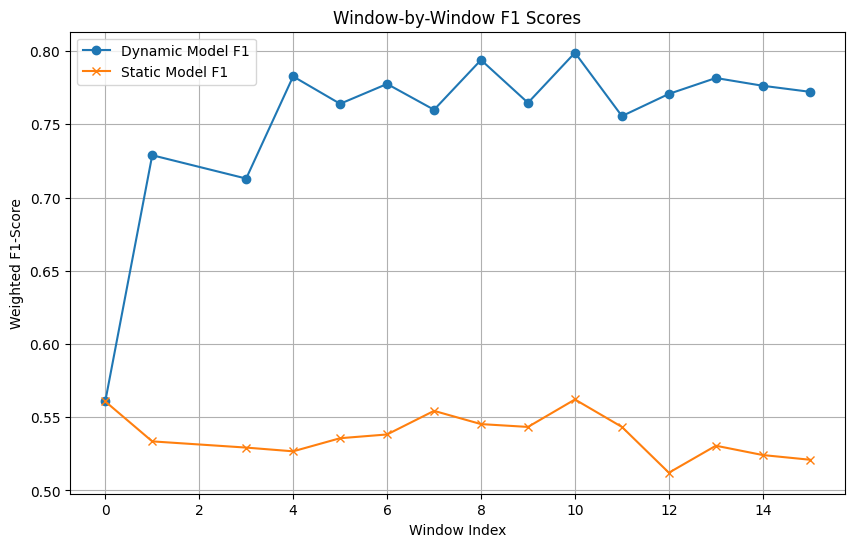

In [8]:
import matplotlib.pyplot as plt

# Plotting F1 scores per window
plt.figure(figsize=(10, 6))
plt.plot(window_indices, dynamic_model_f1, label='Dynamic Model F1', marker='o')
plt.plot(window_indices, static_model_f1, label='Static Model F1', marker='x')
plt.xlabel('Window Index')
plt.ylabel('Weighted F1-Score')
plt.title('Window-by-Window F1 Scores')
plt.legend()
plt.grid(True)
plt.show()


<h2>Streaming using ADWIN </h2>

In [8]:
for idx, message in enumerate(consumer):
    # Data processing (unchanged)
    row = message.value.decode().strip().split(',')
    
    try:
        row_df = pd.DataFrame([row], columns=[*feature_columns, 'label'])
    except ValueError:
        print(f"Skipping invalid row: {row}")
        continue
    
    if 'Unnamed: 0' in row_df.columns:
        row_df.drop('Unnamed: 0', axis=1, inplace=True)
    
    if 'label' in row_df.columns:
        row_df['label'] = row_df['label'].apply(lambda x: x.strip().replace('\\n"', '').replace('"', ''))
        # Ensure the 'label' column contains valid integers
        row_df = row_df[pd.to_numeric(row_df['label'], errors='coerce').notnull()]
        if row_df.empty:
            print(f"Skipping row with invalid label: {row}")
            continue
        row_df['label'] = row_df['label'].astype(int)
    
    for col in feature_columns:
        row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)

    # Feature scaling and data collection
    row_df[feature_columns] = dynamic_scaler.transform(row_df[feature_columns])
    X_new = row_df[feature_columns].values
    y_new = int(row_df['label'].values[0])
    
    window_data.append((X_new[0], y_new))
    replay_buffer.append((X_new[0], y_new))

    # ADWIN update with single-sample predictions
    with torch.no_grad():
        # Dynamic model prediction
        X_tensor = torch.tensor(X_new, dtype=torch.float32)
        edge_dummy = torch.zeros((2, 1), dtype=torch.long)  # Dummy edge index
        dynamic_pred = dynamic_model(X_tensor, edge_dummy).argmax().item()
        static_pred = static_model(X_tensor, edge_dummy).argmax().item()

    # Update ADWIN with correctness (1=correct, 0=error)
    adwin_dynamic.update(1 if dynamic_pred == y_new else 0)
    adwin_static.update(1 if static_pred == y_new else 0)

    # Window processing
    if len(window_data) == window_size:
        current_window = list(window_data)
        sample_size = min(len(current_window), len(replay_buffer))
        replay_samples = [replay_buffer[i] for i in np.random.choice(len(replay_buffer), sample_size, replace=False)] if sample_size > 0 else []
        combined = current_window + replay_samples

        # Prepare data
        X_window = np.array([entry[0] for entry in combined])
        y_window = np.array([entry[1] for entry in combined])
        X_window_df = pd.DataFrame(X_window, columns=feature_columns)

        # Generate model inputs
        X_window_dynamic = dynamic_scaler.transform(X_window_df)
        X_window_static = static_scaler.transform(X_window_df)
        
        # Create graph
        k = 5
        knn_graph = kneighbors_graph(X_window, n_neighbors=k, include_self=False)
        row_idx, col_idx = knn_graph.nonzero()
        edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)
        
        # Convert to tensors
        X_window_dynamic_tensor = torch.tensor(X_window_dynamic, dtype=torch.float32)
        X_window_static_tensor = torch.tensor(X_window_static, dtype=torch.float32)
        y_window_tensor = torch.tensor(y_window, dtype=torch.long)

        # Get predictions
        with torch.no_grad():
            dynamic_logits = dynamic_model(X_window_dynamic_tensor, edge_index)
            static_logits = static_model(X_window_static_tensor, edge_index)
        dynamic_preds = dynamic_logits.argmax(dim=1).cpu().numpy()
        static_preds = static_logits.argmax(dim=1).cpu().numpy()

        # Calculate metrics
        current_dynamic_f1 = f1_score(y_window, dynamic_preds, average='weighted', zero_division=0)
        current_static_f1 = f1_score(y_window, static_preds, average='weighted', zero_division=0)
        current_precision = precision_score(y_window, dynamic_preds, average='weighted', zero_division=0)
        current_recall = recall_score(y_window, dynamic_preds, average='weighted', zero_division=0)
        
        # Store metrics
        dynamic_model_f1.append(current_dynamic_f1)
        static_model_f1.append(current_static_f1)
        window_indices.append(idx // window_size)

        # Drift detection and handling
        if adwin_dynamic.drift_detected:
            print(f"\nDrift detected in dynamic model at window {window_count}! Retraining...")
            
            # Update scaler
            new_scaler = StandardScaler().fit(X_window_df)
            dynamic_scaler.mean_ = (1 - ema_alpha)*dynamic_scaler.mean_ + ema_alpha*new_scaler.mean_
            dynamic_scaler.scale_ = (1 - ema_alpha)*dynamic_scaler.scale_ + ema_alpha*new_scaler.scale_
            
            # Prepare retraining data
            X_scaled = dynamic_scaler.transform(X_window_df)
            knn_graph = kneighbors_graph(X_scaled, n_neighbors=k, include_self=False)
            row_idx, col_idx = knn_graph.nonzero()
            edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)
            X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
            
            # Retrain model
            dynamic_model.train()
            optimizer = optim.Adam(dynamic_model.parameters(), lr=0.01)
            criterion = nn.CrossEntropyLoss()
            
            for epoch in range(1, 81):
                optimizer.zero_grad()
                outputs = dynamic_model(X_tensor, edge_index)
                loss = criterion(outputs, y_window_tensor)
                loss.backward()
                optimizer.step()
                if epoch % 20 == 0:
                    print(f"Epoch {epoch}/80 - Loss: {loss.item():.4f}")
            
            dynamic_model.eval()
            adwin_dynamic.reset()

        # Static model monitoring
        if adwin_static.drift_detected:
            print(f"Static model drift detected (F1: {current_static_f1:.3f})")

        # Window cleanup
        window_data.clear()
        window_count += 1
        if window_count >= max_window_steps:
            print(f"Reached max window steps ({max_window_steps}). Exiting...")
            break

C:\Users\akash\AppData\Local\Temp\ipykernel_14316\225444659.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)


Skipping row with invalid label: ['"destination port', 'flow duration', 'total fwd packets', 'total backward packets', 'total length of fwd packets', 'total length of bwd packets', 'fwd packet length max', 'fwd packet length min', 'fwd packet length mean', 'fwd packet length std', 'bwd packet length max', 'bwd packet length min', 'bwd packet length mean', 'bwd packet length std', 'flow bytes/s', 'flow packets/s', 'flow iat mean', 'flow iat std', 'flow iat max', 'flow iat min', 'fwd iat total', 'fwd iat mean', 'fwd iat std', 'fwd iat max', 'fwd iat min', 'bwd iat total', 'bwd iat mean', 'bwd iat std', 'bwd iat max', 'bwd iat min', 'fwd psh flags', 'bwd psh flags', 'fwd urg flags', 'bwd urg flags', 'fwd header length', 'bwd header length', 'fwd packets/s', 'bwd packets/s', 'min packet length', 'max packet length', 'packet length mean', 'packet length std', 'packet length variance', 'fin flag count', 'syn flag count', 'rst flag count', 'psh flag count', 'ack flag count', 'urg flag count',

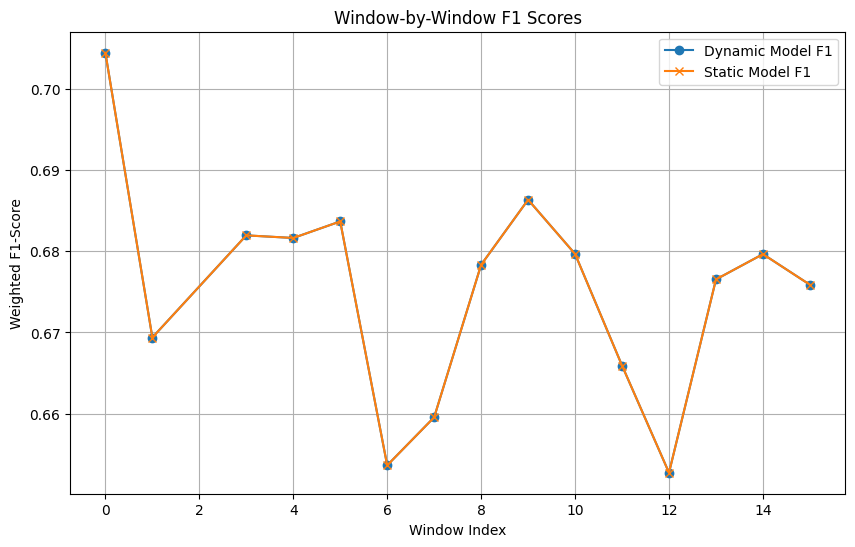

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(window_indices, dynamic_model_f1, label='Dynamic Model F1', marker='o')
plt.plot(window_indices, static_model_f1, label='Static Model F1', marker='x')
plt.xlabel('Window Index')
plt.ylabel('Weighted F1-Score')
plt.title('Window-by-Window F1 Scores')
plt.legend()
plt.grid(True)
plt.show()

<h2>Streaming using PageHinkley</h2>

In [14]:
static_model = model
dynamic_model = copy.deepcopy(model)

In [15]:
static_scaler = scaler
dynamic_scaler = copy.deepcopy(scaler)

feature_columns = scaler.feature_names_in_  # list of feature column names
window_size = 1000
max_window_steps = 15
window_count = 0
window_data = deque(maxlen=window_size)

replay_buffer = deque(maxlen=2000)

dynamic_model_f1 = []
static_model_f1 = []
window_indices = []

ema_alpha = 0.3

ph_dynamic = drift.PageHinkley()
ph_static = drift.PageHinkley()

In [16]:
for idx, message in enumerate(consumer):
    # Data processing (unchanged)
    row = message.value.decode().strip().split(',')
    
    try:
        row_df = pd.DataFrame([row], columns=[*feature_columns, 'label'])
    except ValueError:
        print(f"Skipping invalid row: {row}")
        continue
    
    if 'Unnamed: 0' in row_df.columns:
        row_df.drop('Unnamed: 0', axis=1, inplace=True)
    
    if 'label' in row_df.columns:
        row_df['label'] = row_df['label'].apply(lambda x: x.strip().replace('\\n"', '').replace('"', ''))
        # Ensure the 'label' column contains valid integers
        row_df = row_df[pd.to_numeric(row_df['label'], errors='coerce').notnull()]
        if row_df.empty:
            print(f"Skipping row with invalid label: {row}")
            continue
        row_df['label'] = row_df['label'].astype(int)
    
    for col in feature_columns:
        row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)

    # Feature scaling and data collection
    row_df[feature_columns] = dynamic_scaler.transform(row_df[feature_columns])
    X_new = row_df[feature_columns].values
    y_new = int(row_df['label'].values[0])
    
    window_data.append((X_new[0], y_new))
    replay_buffer.append((X_new[0], y_new))

    # PH update with single-sample predictions
    with torch.no_grad():
        # Dynamic model prediction
        X_tensor = torch.tensor(X_new, dtype=torch.float32)
        edge_dummy = torch.zeros((2, 1), dtype=torch.long)  # Dummy edge index
        dynamic_pred = dynamic_model(X_tensor, edge_dummy).argmax().item()
        static_pred = static_model(X_tensor, edge_dummy).argmax().item()

    # Update PH with correctness (1=correct, 0=error)
    ph_dynamic.update(1 if dynamic_pred == y_new else 0)
    ph_static.update(1 if static_pred == y_new else 0)

    # Window processing
    if len(window_data) == window_size:
        current_window = list(window_data)
        sample_size = min(len(current_window), len(replay_buffer))
        replay_samples = [replay_buffer[i] for i in np.random.choice(len(replay_buffer), sample_size, replace=False)] if sample_size > 0 else []
        combined = current_window + replay_samples

        # Prepare data
        X_window = np.array([entry[0] for entry in combined])
        y_window = np.array([entry[1] for entry in combined])
        X_window_df = pd.DataFrame(X_window, columns=feature_columns)

        # Generate model inputs
        X_window_dynamic = dynamic_scaler.transform(X_window_df)
        X_window_static = static_scaler.transform(X_window_df)
        
        # Create graph
        k = 5
        knn_graph = kneighbors_graph(X_window, n_neighbors=k, include_self=False)
        row_idx, col_idx = knn_graph.nonzero()
        edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)
        
        # Convert to tensors
        X_window_dynamic_tensor = torch.tensor(X_window_dynamic, dtype=torch.float32)
        X_window_static_tensor = torch.tensor(X_window_static, dtype=torch.float32)
        y_window_tensor = torch.tensor(y_window, dtype=torch.long)

        # Get predictions
        with torch.no_grad():
            dynamic_logits = dynamic_model(X_window_dynamic_tensor, edge_index)
            static_logits = static_model(X_window_static_tensor, edge_index)
        dynamic_preds = dynamic_logits.argmax(dim=1).cpu().numpy()
        static_preds = static_logits.argmax(dim=1).cpu().numpy()

        # Calculate metrics
        current_dynamic_f1 = f1_score(y_window, dynamic_preds, average='weighted', zero_division=0)
        current_static_f1 = f1_score(y_window, static_preds, average='weighted', zero_division=0)
        current_precision = precision_score(y_window, dynamic_preds, average='weighted', zero_division=0)
        current_recall = recall_score(y_window, dynamic_preds, average='weighted', zero_division=0)
        
        # Store metrics
        dynamic_model_f1.append(current_dynamic_f1)
        static_model_f1.append(current_static_f1)
        window_indices.append(idx // window_size)

        # Drift detection and handling
        if ph_dynamic.drift_detected:
            print(f"\nDrift detected in dynamic model at window {window_count}! Retraining...")
            
            # Update scaler
            new_scaler = StandardScaler().fit(X_window_df)
            dynamic_scaler.mean_ = (1 - ema_alpha)*dynamic_scaler.mean_ + ema_alpha*new_scaler.mean_
            dynamic_scaler.scale_ = (1 - ema_alpha)*dynamic_scaler.scale_ + ema_alpha*new_scaler.scale_
            
            # Prepare retraining data
            X_scaled = dynamic_scaler.transform(X_window_df)
            knn_graph = kneighbors_graph(X_scaled, n_neighbors=k, include_self=False)
            row_idx, col_idx = knn_graph.nonzero()
            edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)
            X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
            
            # Retrain model
            dynamic_model.train()
            optimizer = optim.Adam(dynamic_model.parameters(), lr=0.01)
            criterion = nn.CrossEntropyLoss()
            
            for epoch in range(1, 81):
                optimizer.zero_grad()
                outputs = dynamic_model(X_tensor, edge_index)
                loss = criterion(outputs, y_window_tensor)
                loss.backward()
                optimizer.step()
                if epoch % 20 == 0:
                    print(f"Epoch {epoch}/80 - Loss: {loss.item():.4f}")
            
            dynamic_model.eval()
            ph_dynamic.reset()

        # Static model monitoring
        if ph_static.drift_detected:
            print(f"Static model drift detected (F1: {current_static_f1:.3f})")

        # Window cleanup
        window_data.clear()
        window_count += 1
        if window_count >= max_window_steps:
            print(f"Reached max window steps ({max_window_steps}). Exiting...")
            break

Skipping row with invalid label: ['"destination port', 'flow duration', 'total fwd packets', 'total backward packets', 'total length of fwd packets', 'total length of bwd packets', 'fwd packet length max', 'fwd packet length min', 'fwd packet length mean', 'fwd packet length std', 'bwd packet length max', 'bwd packet length min', 'bwd packet length mean', 'bwd packet length std', 'flow bytes/s', 'flow packets/s', 'flow iat mean', 'flow iat std', 'flow iat max', 'flow iat min', 'fwd iat total', 'fwd iat mean', 'fwd iat std', 'fwd iat max', 'fwd iat min', 'bwd iat total', 'bwd iat mean', 'bwd iat std', 'bwd iat max', 'bwd iat min', 'fwd psh flags', 'bwd psh flags', 'fwd urg flags', 'bwd urg flags', 'fwd header length', 'bwd header length', 'fwd packets/s', 'bwd packets/s', 'min packet length', 'max packet length', 'packet length mean', 'packet length std', 'packet length variance', 'fin flag count', 'syn flag count', 'rst flag count', 'psh flag count', 'ack flag count', 'urg flag count',

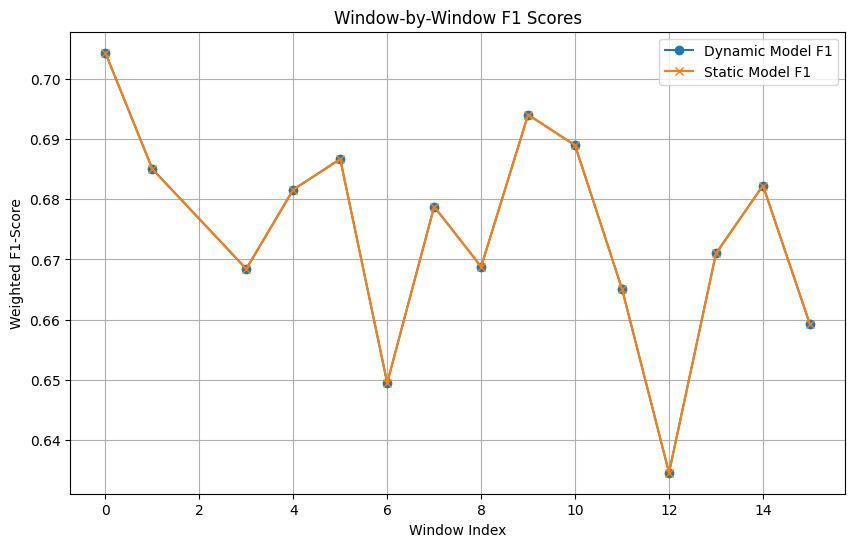

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(window_indices, dynamic_model_f1, label='Dynamic Model F1', marker='o')
plt.plot(window_indices, static_model_f1, label='Static Model F1', marker='x')
plt.xlabel('Window Index')
plt.ylabel('Weighted F1-Score')
plt.title('Window-by-Window F1 Scores')
plt.legend()
plt.grid(True)
plt.show()

<h2>Stream with KSWIN </h2>

In [22]:
static_model = model
dynamic_model = copy.deepcopy(model)

In [23]:
static_scaler = scaler
dynamic_scaler = copy.deepcopy(scaler)

feature_columns = scaler.feature_names_in_  # list of feature column names
window_size = 1000
max_window_steps = 15
window_count = 0
window_data = deque(maxlen=window_size)

replay_buffer = deque(maxlen=2000)

dynamic_model_f1 = []
static_model_f1 = []
window_indices = []

ema_alpha = 0.3

kswin_dynamic = drift.KSWIN(seed=2021)
kswin_static = drift.KSWIN(seed=2021)

In [24]:
for idx, message in enumerate(consumer):
    # Data processing (unchanged)
    row = message.value.decode().strip().split(',')
    
    try:
        row_df = pd.DataFrame([row], columns=[*feature_columns, 'label'])
    except ValueError:
        print(f"Skipping invalid row: {row}")
        continue
    
    if 'Unnamed: 0' in row_df.columns:
        row_df.drop('Unnamed: 0', axis=1, inplace=True)
    
    if 'label' in row_df.columns:
        row_df['label'] = row_df['label'].apply(lambda x: x.strip().replace('\\n"', '').replace('"', ''))
        # Ensure the 'label' column contains valid integers
        row_df = row_df[pd.to_numeric(row_df['label'], errors='coerce').notnull()]
        if row_df.empty:
            print(f"Skipping row with invalid label: {row}")
            continue
        row_df['label'] = row_df['label'].astype(int)
    
    for col in feature_columns:
        row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)

    # Feature scaling and data collection
    row_df[feature_columns] = dynamic_scaler.transform(row_df[feature_columns])
    X_new = row_df[feature_columns].values
    y_new = int(row_df['label'].values[0])
    
    window_data.append((X_new[0], y_new))
    replay_buffer.append((X_new[0], y_new))

    # KSWIN update with single-sample predictions
    with torch.no_grad():
        # Dynamic model prediction
        X_tensor = torch.tensor(X_new, dtype=torch.float32)
        edge_dummy = torch.zeros((2, 1), dtype=torch.long)  # Dummy edge index
        dynamic_pred = dynamic_model(X_tensor, edge_dummy).argmax().item()
        static_pred = static_model(X_tensor, edge_dummy).argmax().item()

    # Update KSWIN with correctness (1=correct, 0=error)
    kswin_dynamic.update(1 if dynamic_pred == y_new else 0)
    kswin_static.update(1 if static_pred == y_new else 0)

    # Window processing
    if len(window_data) == window_size:
        current_window = list(window_data)
        sample_size = min(len(current_window), len(replay_buffer))
        replay_samples = [replay_buffer[i] for i in np.random.choice(len(replay_buffer), sample_size, replace=False)] if sample_size > 0 else []
        combined = current_window + replay_samples

        # Prepare data
        X_window = np.array([entry[0] for entry in combined])
        y_window = np.array([entry[1] for entry in combined])
        X_window_df = pd.DataFrame(X_window, columns=feature_columns)

        # Generate model inputs
        X_window_dynamic = dynamic_scaler.transform(X_window_df)
        X_window_static = static_scaler.transform(X_window_df)
        
        # Create graph
        k = 5
        knn_graph = kneighbors_graph(X_window, n_neighbors=k, include_self=False)
        row_idx, col_idx = knn_graph.nonzero()
        edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)
        
        # Convert to tensors
        X_window_dynamic_tensor = torch.tensor(X_window_dynamic, dtype=torch.float32)
        X_window_static_tensor = torch.tensor(X_window_static, dtype=torch.float32)
        y_window_tensor = torch.tensor(y_window, dtype=torch.long)

        # Get predictions
        with torch.no_grad():
            dynamic_logits = dynamic_model(X_window_dynamic_tensor, edge_index)
            static_logits = static_model(X_window_static_tensor, edge_index)
        dynamic_preds = dynamic_logits.argmax(dim=1).cpu().numpy()
        static_preds = static_logits.argmax(dim=1).cpu().numpy()

        # Calculate metrics
        current_dynamic_f1 = f1_score(y_window, dynamic_preds, average='weighted', zero_division=0)
        current_static_f1 = f1_score(y_window, static_preds, average='weighted', zero_division=0)
        current_precision = precision_score(y_window, dynamic_preds, average='weighted', zero_division=0)
        current_recall = recall_score(y_window, dynamic_preds, average='weighted', zero_division=0)
        
        # Store metrics
        dynamic_model_f1.append(current_dynamic_f1)
        static_model_f1.append(current_static_f1)
        window_indices.append(idx // window_size)

        # Drift detection and handling
        if kswin_dynamic.drift_detected:
            print(f"\nDrift detected in dynamic model at window {window_count}! Retraining...")
            
            # Update scaler
            new_scaler = StandardScaler().fit(X_window_df)
            dynamic_scaler.mean_ = (1 - ema_alpha)*dynamic_scaler.mean_ + ema_alpha*new_scaler.mean_
            dynamic_scaler.scale_ = (1 - ema_alpha)*dynamic_scaler.scale_ + ema_alpha*new_scaler.scale_
            
            # Prepare retraining data
            X_scaled = dynamic_scaler.transform(X_window_df)
            knn_graph = kneighbors_graph(X_scaled, n_neighbors=k, include_self=False)
            row_idx, col_idx = knn_graph.nonzero()
            edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)
            X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
            
            # Retrain model
            dynamic_model.train()
            optimizer = optim.Adam(dynamic_model.parameters(), lr=0.01)
            criterion = nn.CrossEntropyLoss()
            
            for epoch in range(1, 81):
                optimizer.zero_grad()
                outputs = dynamic_model(X_tensor, edge_index)
                loss = criterion(outputs, y_window_tensor)
                loss.backward()
                optimizer.step()
                if epoch % 20 == 0:
                    print(f"Epoch {epoch}/80 - Loss: {loss.item():.4f}")
            
            dynamic_model.eval()
            kswin_dynamic.reset()

        # Static model monitoring
        if kswin_static.drift_detected:
            print(f"Static model drift detected (F1: {current_static_f1:.3f})")

        # Window cleanup
        window_data.clear()
        window_count += 1
        if window_count >= max_window_steps:
            print(f"Reached max window steps ({max_window_steps}). Exiting...")
            break

Skipping row with invalid label: ['"destination port', 'flow duration', 'total fwd packets', 'total backward packets', 'total length of fwd packets', 'total length of bwd packets', 'fwd packet length max', 'fwd packet length min', 'fwd packet length mean', 'fwd packet length std', 'bwd packet length max', 'bwd packet length min', 'bwd packet length mean', 'bwd packet length std', 'flow bytes/s', 'flow packets/s', 'flow iat mean', 'flow iat std', 'flow iat max', 'flow iat min', 'fwd iat total', 'fwd iat mean', 'fwd iat std', 'fwd iat max', 'fwd iat min', 'bwd iat total', 'bwd iat mean', 'bwd iat std', 'bwd iat max', 'bwd iat min', 'fwd psh flags', 'bwd psh flags', 'fwd urg flags', 'bwd urg flags', 'fwd header length', 'bwd header length', 'fwd packets/s', 'bwd packets/s', 'min packet length', 'max packet length', 'packet length mean', 'packet length std', 'packet length variance', 'fin flag count', 'syn flag count', 'rst flag count', 'psh flag count', 'ack flag count', 'urg flag count',

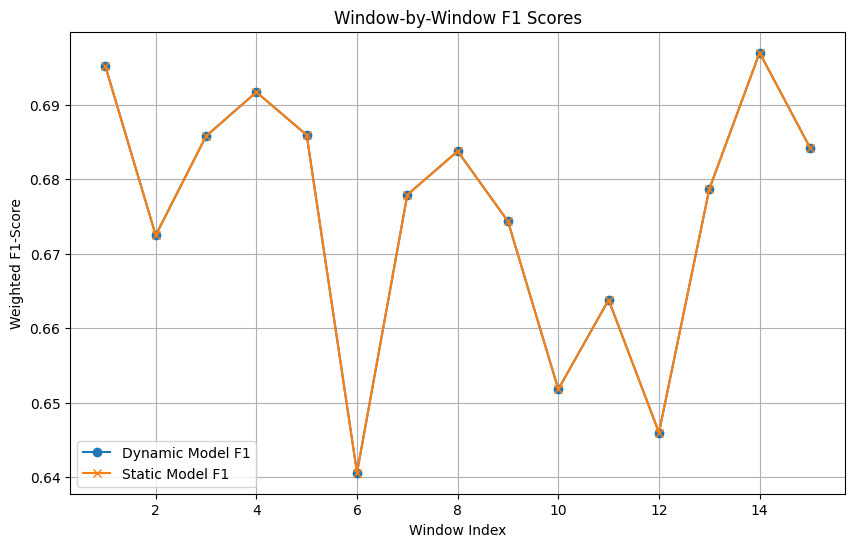

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(window_indices, dynamic_model_f1, label='Dynamic Model F1', marker='o')
plt.plot(window_indices, static_model_f1, label='Static Model F1', marker='x')
plt.xlabel('Window Index')
plt.ylabel('Weighted F1-Score')
plt.title('Window-by-Window F1 Scores')
plt.legend()
plt.grid(True)
plt.show()